In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
img_files = os.listdir('/Users/yao/Desktop/detection/training_set/')         # 改
img_files = list(filter(lambda x: x != 'training_set', img_files))
def train_path(p): return f"/Users/yao/Desktop/detection/training_set/{p}"
img_files = list(map(train_path, img_files))

print("total training images", len(img_files))
print("First item", img_files[0])

total training images 5616
First item /Users/yao/Desktop/detection/training_set/@anyuser_1495977824922275840_tweetcapture.png


In [3]:
random.shuffle(img_files)

train = img_files[:4493]  # 改
test = img_files[4493:]

print("train size", len(train))
print("test size", len(test))


train size 4493
test size 1123


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
class tweetdataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'anyuser' in path else 1
        return (image, label)


In [6]:
train_ds = tweetdataset(train, transform)
train_dl = DataLoader(train_ds, batch_size=100)
print(len(train_ds), len(train_dl))


4493 45


In [7]:
test_ds = tweetdataset(test, transform)
test_dl = DataLoader(test_ds, batch_size=100)
print(len(test_ds), len(test_dl))

1123 12


In [8]:
class tweetscreenshot(nn.Module):

    def __init__(self):
        super().__init__()

        # onvolutional layers (3,16,32)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)

        # conected layers
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X

In [9]:
model = tweetscreenshot()

losses = []
accuracies = []
epoches = 3
start = time.time()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
for epoch in range(epoches):

    epoch_loss = 0
    epoch_accuracy = 0

    for X, y in train_dl:
        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)

    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)

    print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))
    
    with torch.no_grad():

        test_epoch_loss = 0
        test_epoch_accuracy = 0

        for test_X, test_y in test_dl:

            test_preds = model(test_X)
            test_loss = loss_fn(test_preds, test_y)

            test_epoch_loss += test_loss            
            test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
            test_epoch_accuracy += test_accuracy

        test_epoch_accuracy = test_epoch_accuracy/len(test_dl)
        test_epoch_loss = test_epoch_loss / len(test_dl)

        print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy, time.time() - start))

..........................

/Users/yao/miniconda3/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


...................
 --- Epoch: 0, train loss: 0.3055, train acc: 0.8868, time: 111.6620991230011
Epoch: 0, test loss: 0.1422, test acc: 0.9530, time: 134.56998109817505

.............................................
 --- Epoch: 1, train loss: 0.0974, train acc: 0.9682, time: 244.9448471069336
Epoch: 1, test loss: 0.0537, test acc: 0.9825, time: 269.7083032131195

.............................................
 --- Epoch: 2, train loss: 0.0642, train acc: 0.9796, time: 385.16543102264404
Epoch: 2, test loss: 0.0542, test acc: 0.9797, time: 411.004301071167



In [15]:
test_files = os.listdir('/Users/yao/Desktop/detection/test_set/')
test_files = list(filter(lambda x: x != 'test_set', test_files))
def test_path(p): return f"/Users/yao/Desktop/detection/test_set/{p}"
test_files = list(map(test_path, test_files))

class Test(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        fileid = path.split('/')[-1].split('.')[0]
        return (image, fileid)

test_ds = Test(test_files, transform)
test_dl = DataLoader(test_ds, batch_size=100)
len(test_ds), len(test_dl)


(1403, 15)

In [16]:
screenshot_probs = []

with torch.no_grad():
    for X, fileid in test_dl:
        preds = model(X)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        screenshot_probs += list(zip(list(fileid), preds_list))



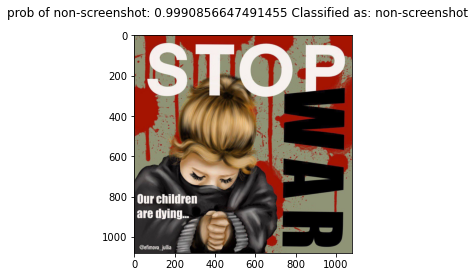

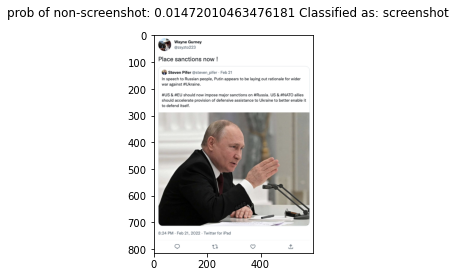

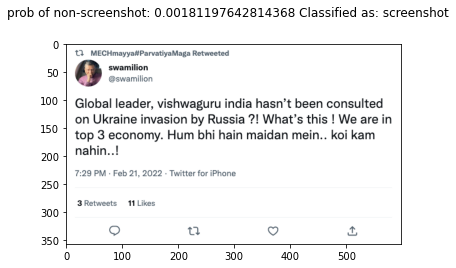

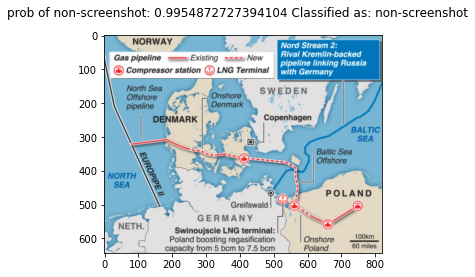

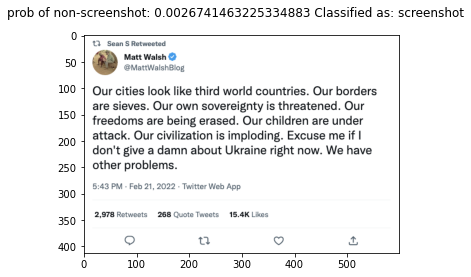

In [25]:
# display some images
for img, probs in zip(test_files[:5], screenshot_probs[:5]):
    pil_im = Image.open(img, 'r')
    label = "non-screenshot" if probs[1] > 0.5 else "screenshot"
    title = "prob of non-screenshot: " + str(probs[1]) + " Classified as: " + label
    plt.figure()
    plt.imshow(pil_im)
    plt.suptitle(title)
    plt.show()